In [57]:
from fastai import *
from fastai.vision import *
import torch.onnx
from torch.autograd import Variable

import netron

In [2]:
import os

os.environ["TORCH_HOME"] = "/media/subhaditya/DATA/COSMO/Datasets-Useful"

In [9]:
path = untar_data(URLs.CIFAR)

In [13]:
data = (
    (
        ImageList.from_folder(path)
        .split_by_rand_pct()
        .label_from_folder()
        .transform(get_transforms(), size=224)
    )
    .databunch(bs=64)
    .normalize(imagenet_stats)
)

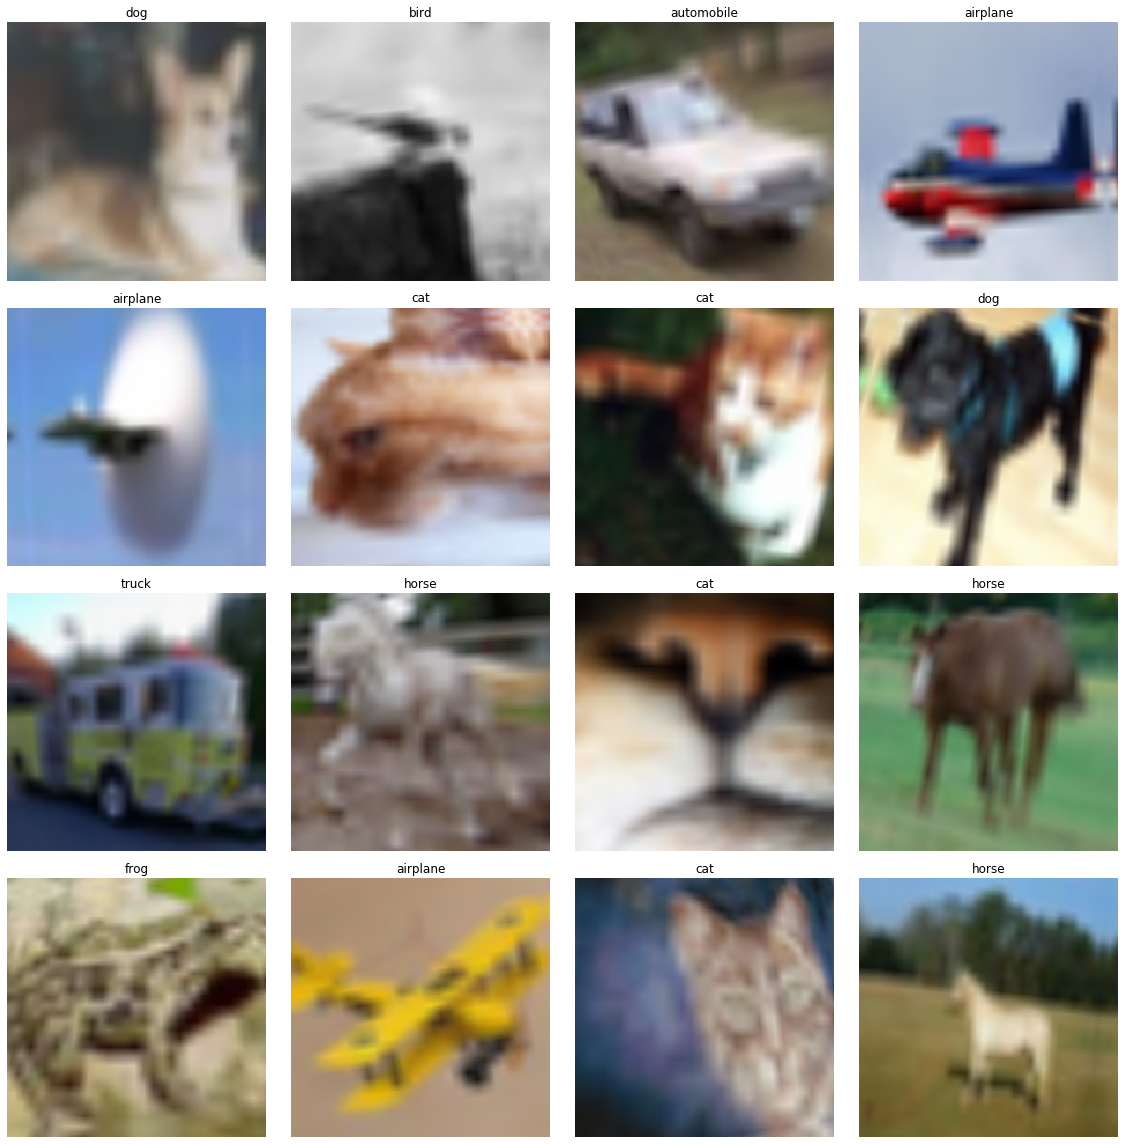

In [14]:
data.show_batch(4)

In [15]:
data.c

10

In [16]:
data

ImageDataBunch;

Train: LabelList (48000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
frog,frog,frog,frog,frog
Path: /home/subhaditya/.fastai/data/cifar10;

Valid: LabelList (12000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
horse,deer,airplane,automobile,frog
Path: /home/subhaditya/.fastai/data/cifar10;

Test: None

In [42]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.part1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2),
        )
        self.part2 = nn.AdaptiveAvgPool2d((6, 6))
        self.part3 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.part1(x)
        x = self.part2(x)
        x = torch.flatten(x, 1)
        x = self.part3(x)

        return x

In [47]:
learn = None
gc.collect()

14812

In [50]:
learn = Learner(
    data, Model(), metrics=[accuracy], opt_func=AdamW, callback_fns=ShowGraph
).to_fp16()

In [52]:
learn.summary()

Model
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 55, 55]         23,296     True      
______________________________________________________________________
ReLU                 [64, 55, 55]         0          False     
______________________________________________________________________
MaxPool2d            [64, 27, 27]         0          False     
______________________________________________________________________
Conv2d               [192, 27, 27]        307,392    True      
______________________________________________________________________
ReLU                 [192, 27, 27]        0          False     
______________________________________________________________________
MaxPool2d            [192, 13, 13]        0          False     
______________________________________________________________________
Conv2d               [384, 13, 13]        663,936    True      
________________________________________________________

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


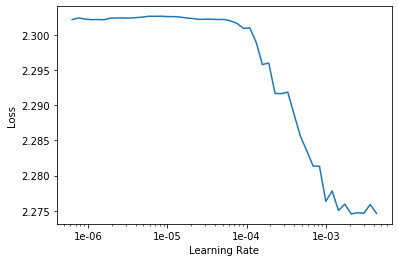

In [51]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,2.276230,2.189647,0.160250,02:57
1,2.303115,2.302866,0.097500,00:48
2,2.302806,2.303211,0.098667,00:50
3,2.302735,2.302752,0.099333,00:50
4,2.302588,2.302706,0.099333,00:52


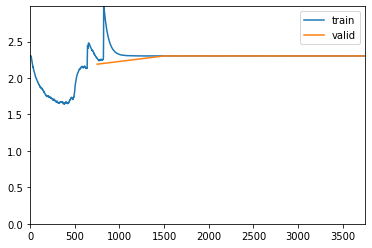

In [46]:
learn.fit_one_cycle(5, 5e-3)

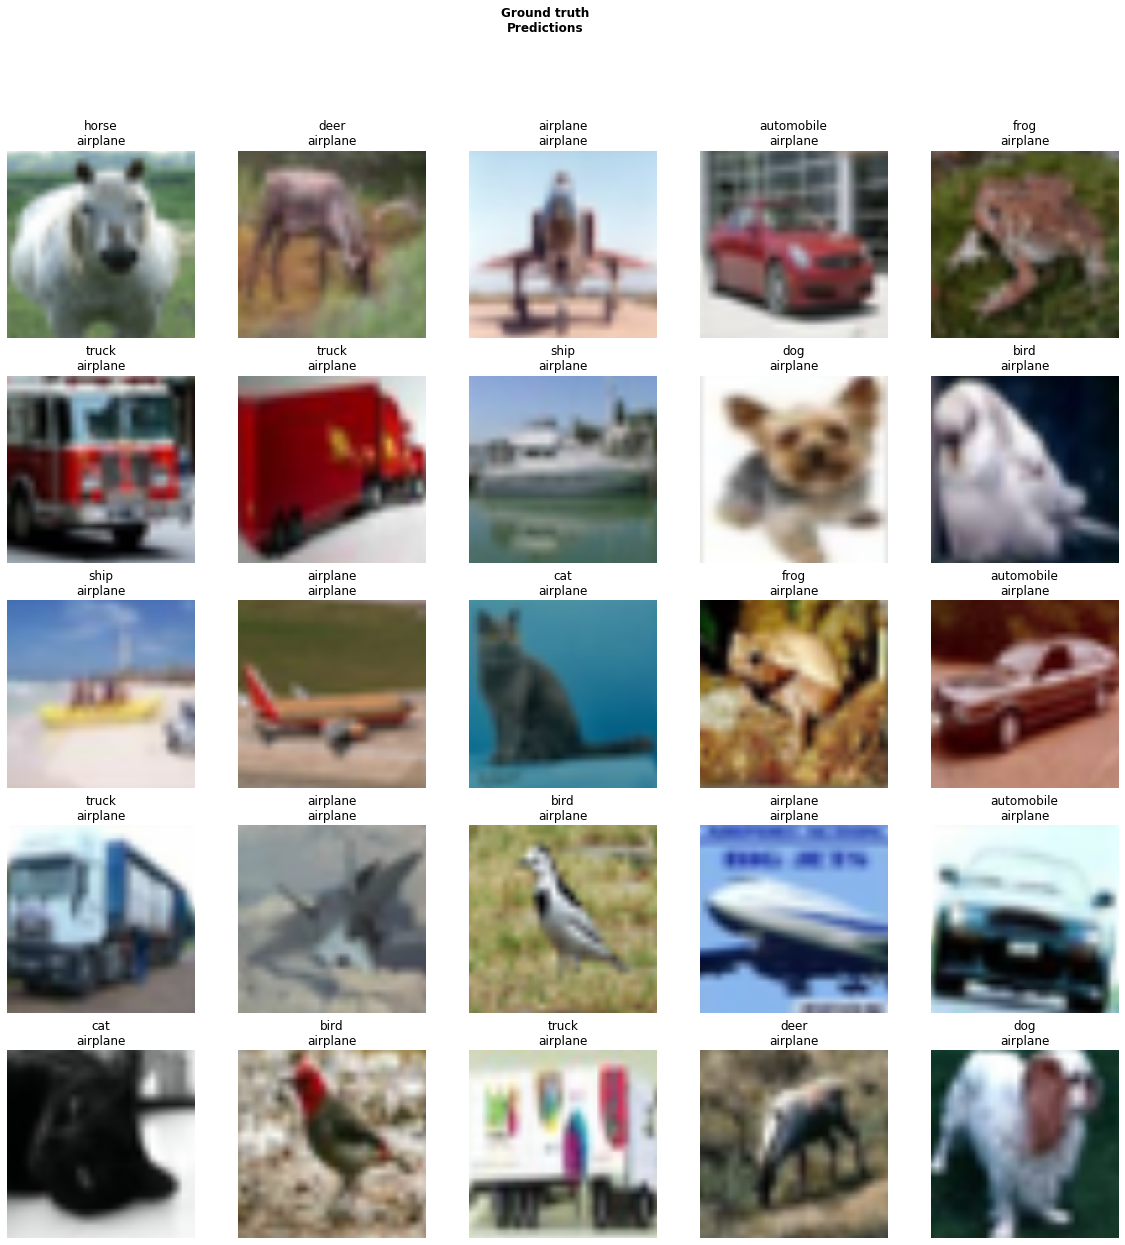

In [54]:
learn.show_results()

In [59]:
dummy_input = Variable(torch.randn(1, 3, 224, 224)).cuda().half()
torch.onnx.export(learn.model, dummy_input, "model.onnx")

In [60]:
netron.start("model.onnx")

Serving 'model.onnx' at http://localhost:8080


In [61]:
!rm "model.onnx"